In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

/data/titeev/diplom/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
# train_data = pd.read_csv('data/texts_data_with_clusters_gigachat_v2.csv')
# test_data = pd.read_csv('data/test.csv')

train_data = pd.read_csv('data/train_dataset.csv')
test_data = pd.read_csv('data/test_dataset.csv')

In [4]:
train_data = train_data.dropna()
test_data = test_data.dropna()

## Make Embeddings

In [5]:
model = SentenceTransformer("ai-forever/FRIDA")

In [6]:
train_texts = train_data["text"].tolist()
test_texts = test_data["text"].tolist()

In [ ]:
batch_size = 64
embeddings = []
for i in tqdm(range(0, len(train_texts), batch_size), desc="Encoding texts"):
    batch_texts = train_texts[i:i+batch_size]
    batch_embeddings = model.encode(batch_texts, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
    embeddings.append(batch_embeddings)

all_embeddings = np.vstack(embeddings)

embeddings_df = pd.DataFrame(all_embeddings)
embeddings_df.to_csv("data/train_embeds.csv", index=False)

Encoding texts: 100%|██████████| 1130/1130 [1:01:59<00:00,  3.29s/it]


In [ ]:
batch_size = 64
embeddings = []
for i in tqdm(range(0, len(test_texts), batch_size), desc="Encoding texts"):
    batch_texts = test_texts[i:i+batch_size]
    batch_embeddings = model.encode(batch_texts, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
    embeddings.append(batch_embeddings)

all_embeddings = np.vstack(embeddings)

embeddings_df = pd.DataFrame(all_embeddings)
embeddings_df.to_csv("data/test_embeds.csv", index=False)

Encoding texts: 100%|██████████| 60/60 [03:14<00:00,  3.25s/it]


## Clustering

In [ ]:
train_embs_df = pd.read_csv('./data/train_embeds.csv')
train_embeddings = train_embs_df.values

test_embs_df = pd.read_csv('./data/test_embeds.csv')
test_embeddings = test_embs_df.values

In [6]:
train_embeddings.shape

(72263, 1536)

In [7]:
def plot_with_labels(embeddings, labels, title):
    unique_labels = np.unique(labels)
    plt.figure()
    for label in unique_labels:
        idx = labels == label
        plt.scatter(embeddings[idx, 0], embeddings[idx, 1], label=label, alpha=0.5)
    
    plt.legend()
    plt.title(title)
    plt.show()

def plot_without_labels(embeddings, title):
    plt.figure()
    plt.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.5)
    # plt.legend()
    plt.title(title)
    plt.show()

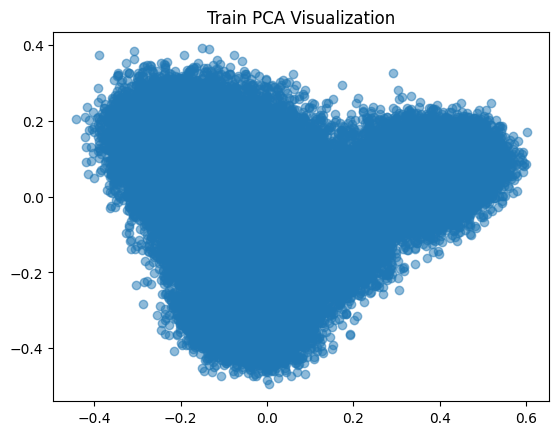

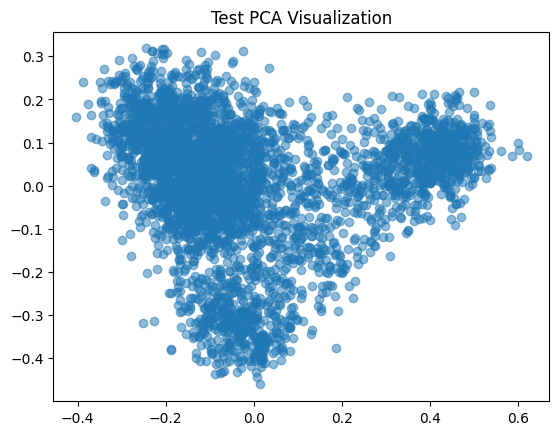

In [8]:
pca = PCA(n_components=2)
train_emb_pca = pca.fit_transform(train_embeddings)
plot_without_labels(train_emb_pca, 'Train PCA Visualization')

test_emb_pca = pca.transform(test_embeddings)
plot_without_labels(test_emb_pca, 'Test PCA Visualization')


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score


In [10]:
def kmeans_clustering(embeddings, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    return labels, kmeans

In [29]:
kmeans_labels, kmeans_model = kmeans_clustering(train_embeddings, n_clusters=30)
test_labels = kmeans_model.predict(test_embeddings)

In [30]:
centers = kmeans_model.cluster_centers_

In [31]:
centers.shape

(30, 1536)

In [32]:
np.unique(kmeans_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32),
 array([2534, 3509, 1903, 1676, 2768, 3123, 1148, 1669, 2376, 4184, 2040,
        1999,  540, 3336, 3321, 3309, 2400, 1614, 1831, 3454, 3989, 2528,
        1655, 2063, 2385, 1408, 3018, 2051, 2161, 2271]))

In [33]:
np.unique(test_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32),
 array([119, 178, 101,  78, 131, 169,  68,  95, 126, 225, 116, 100,  26,
        179, 181, 164, 130,  85,  87, 193, 220, 131,  76, 100, 112,  89,
        171, 111, 108, 135]))

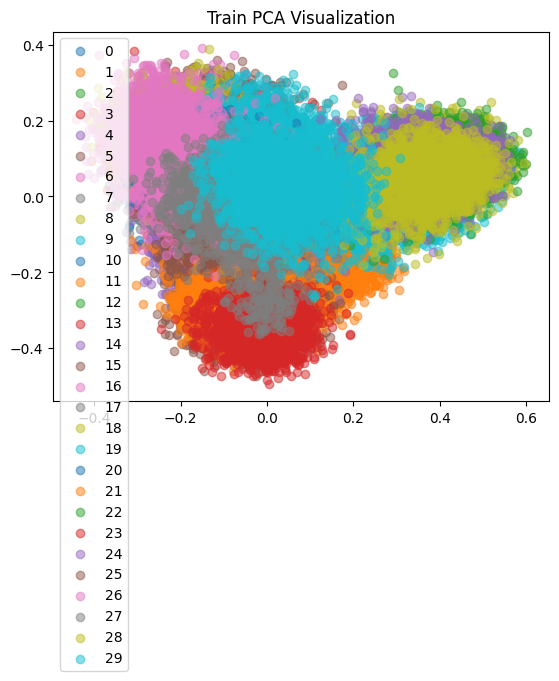

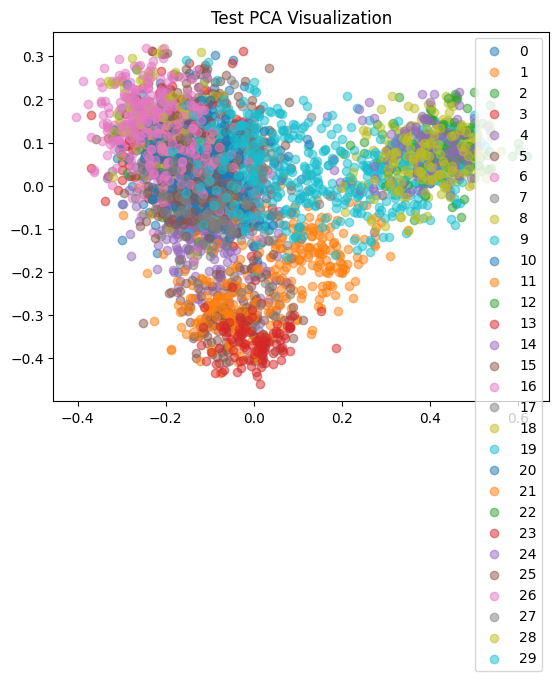

In [34]:
plot_with_labels(train_emb_pca, kmeans_labels, 'Train PCA Visualization')

plot_with_labels(test_emb_pca, test_labels, 'Test PCA Visualization')

In [35]:
new_tran_data = train_data[['text', 'title']]

In [36]:
assert len(new_tran_data) == len(kmeans_labels)

In [37]:
new_tran_data["cluster"] = kmeans_labels

/tmp/ipykernel_3577829/2561641308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_tran_data["cluster"] = kmeans_labels


In [ ]:
new_tran_data.to_csv("./data/new_train_dataset.csv", index=False)

In [39]:
test_data["cluster"] = test_labels

In [ ]:
test_data.to_csv("./data/new_test_dataset.csv", index=False)

In [ ]:
df_centers = pd.DataFrame(centers, columns=[f"dim_{i}" for i in range(centers.shape[1])])
df_centers["cluster_id"] = df_centers.index

# Сохраняем в CSV
df_centers.to_csv("data/cluster_centers.csv", index=False)

In [42]:
df_centers

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_1527,dim_1528,dim_1529,dim_1530,dim_1531,dim_1532,dim_1533,dim_1534,dim_1535,cluster_id
0,0.000024,-0.005514,-0.013799,0.000642,0.003525,-0.000499,0.013855,-0.007437,-0.006567,-0.000608,...,0.007058,0.006682,0.006296,0.000727,0.002957,0.024927,0.001068,-0.020243,0.012390,0
1,-0.013897,-0.018842,0.003483,0.008821,-0.005570,0.012890,-0.001961,-0.004263,0.000334,0.002614,...,-0.003683,0.011832,-0.005427,0.022536,0.003879,0.009430,-0.026112,-0.002135,-0.000803,1
2,-0.025817,-0.039757,-0.021067,-0.000146,-0.002439,0.014131,-0.005805,0.013026,-0.006295,0.009473,...,-0.004528,0.011705,-0.014731,0.006576,-0.001082,0.002005,-0.006257,0.012561,0.024935,2
3,-0.008323,-0.009576,0.009649,0.005771,-0.002732,0.008793,0.011186,-0.009235,-0.035442,-0.023495,...,-0.004640,0.010018,-0.003062,0.014092,0.006532,0.024903,0.003325,0.012360,0.004616,3
4,-0.004729,0.005198,-0.007543,0.012472,-0.003060,0.019924,0.007368,0.003747,-0.014842,-0.003717,...,-0.003623,0.013450,-0.001310,0.000636,0.013781,0.013119,-0.005614,0.001063,0.011977,4
5,-0.012696,-0.008428,-0.019966,-0.002905,0.004562,0.021605,0.010982,-0.008606,-0.027518,0.008596,...,-0.004152,0.009568,-0.019130,0.008787,0.000973,0.007457,-0.005678,-0.007176,0.015474,5
6,-0.007403,-0.016752,-0.024261,0.005504,-0.021389,-0.011353,0.003954,-0.020390,-0.014782,-0.022545,...,0.003765,-0.002094,-0.010859,0.002893,0.001612,0.021331,-0.005726,-0.019604,0.003408,6
7,0.002924,0.001485,-0.001158,-0.004580,-0.014861,0.012098,0.007578,0.020198,-0.004575,-0.000785,...,0.007723,0.009558,0.000804,0.009550,0.006242,0.006009,-0.007372,0.003158,0.001083,7
8,-0.025939,-0.030998,-0.019814,0.005432,-0.000214,0.021182,-0.015452,0.022115,0.007610,0.016906,...,0.001614,0.009745,-0.009718,0.020159,0.004436,0.004767,-0.016659,0.004599,0.027512,8
9,-0.031580,-0.017206,-0.008696,0.002536,0.010932,0.008652,-0.008883,0.003923,0.002962,0.018632,...,-0.010362,0.014632,-0.015698,0.015691,-0.002084,0.007966,-0.019886,0.017592,0.016033,9
